In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt

In [2]:
def locate_index(value,bin_min,step_size,num_bins):
  loc0 = (value-bin_min)/step_size
  if loc0 < 0:
    loc = 0
  elif loc0 >= num_bins:
    loc = num_bins-1
  else:
    loc = int(loc0)
  return loc

def shift_hist(old_hist,shift):
  if shift<0:
    left_end = sum(old_hist[:(abs(shift)+1)])
    rest = old_hist[(abs(shift)+1):]
    fill = np.zeros(len(old_hist)-1-len(rest))
    new_hist = np.concatenate(([left_end],rest,fill))
  elif shift>0:
    right_end = sum(old_hist[-(abs(shift)+1):])
    rest = old_hist[:-(abs(shift)+1)]
    fill = np.zeros(len(old_hist)-1-len(rest))
    new_hist = np.concatenate((fill,rest,[right_end]))
  else:
    new_hist = old_hist
  return new_hist

def ind_hist2tilde(hist_j,loc):
  cumsum = np.cumsum(np.sum(hist_j,axis=0))
  n = cumsum[-1]
  percentile = (cumsum[loc]+1)/(n+2)
  eps_tilde_j = ss.norm.ppf(percentile)
  return eps_tilde_j

def pop_hist2tilde(hist_j,loc):
  cumsum = np.cumsum(hist_j)
  n = cumsum[-1]
  percentile = (cumsum[loc]+1)/(n+2)
  eps_tilde_j = ss.norm.ppf(percentile)
  return eps_tilde_j

def eps2tilde(eps):
  temp = eps.argsort()
  ranks = np.empty_like(temp)
  ranks[temp] = np.arange(len(eps))
  eps_tilde = ss.norm.ppf((ranks+1)/(len(eps)+1))
  return eps_tilde

def compute_mu(memory_vec,period):
  num = (len(memory_vec)//period)*period
  mu = np.mean(memory_vec[np.arange(-num,0)])
  return mu

In [3]:
def pop_initialize(initial_data_dict,r,num_bins):
  memory_dict = initial_data_dict
  pop_hist = {}
  pop_params = {}
  betw_dict = {}
  with_dict = {}
  person_day = 0
  shape = initial_data_dict[list(initial_data_dict.keys())[0]].shape
  if len(shape)==1:
    d = shape[0]
  else:
    d = shape[1]
  pop_params["D"] = d
  ## count how many person_day each user contributed in the initialization
  for ID in initial_data_dict.keys():
    if len(initial_data_dict[ID].shape)==1:
      pop_params[ID]=1
      person_day = person_day + 1
    else:
      pop_params[ID]=initial_data_dict[ID].shape[0]
      person_day = person_day + initial_data_dict[ID].shape[0]
  pop_params["N"] = person_day
  
  ## make histogram for each feature
  for j in range(d):
    temp = []
    for ID in initial_data_dict.keys():
      if len(initial_data_dict[ID].shape)==1:
        temp.append(initial_data_dict[ID][j])
      else:
        temp = temp + initial_data_dict[ID][:,j].tolist()
    temp = np.array(temp)  
    bin_max = max(temp) + r*(max(temp)-min(temp))  ## padding width 0.4*(max-min)
    bin_min = min(temp) - r*(max(temp)-min(temp)) 
    step_size = (bin_max-bin_min)/num_bins
    pop_params[j] = [bin_min,step_size]
    freq = np.zeros(num_bins)
    for i in range(len(temp)):
      loc = locate_index(temp[i],bin_min,step_size,num_bins)
      freq[loc] = freq[loc]+1
    pop_hist[j] = freq
    
  ## use the histogram to compute tilde, and covariance matrix
  all_tilde_dict = {}
  aggregate_tilde = []
  for ID in initial_data_dict.keys():
    all_tilde_list = []
    dat = initial_data_dict[ID]
    if len(dat.shape)==1:
      tilde = np.zeros(len(dat))
      for j in range(len(dat)):
        loc = locate_index(dat[j],pop_params[j][0],pop_params[j][1],num_bins)
        tilde[j] = pop_hist2tilde(pop_hist[j],loc)
      all_tilde_list.append(tilde)
      aggregate_tilde.append(tilde)
    else:
      for i in range(dat.shape[0]):
        tilde = np.zeros(dat.shape[1])
        for j in range(dat.shape[1]):
          loc = locate_index(dat[i,j],pop_params[j][0],pop_params[j][1],num_bins)
          tilde[j] = pop_hist2tilde(pop_hist[j],loc)
        all_tilde_list.append(tilde)
        aggregate_tilde.append(tilde)
    all_tilde_dict[ID] = all_tilde_list
  
  cov = np.cov(np.array(aggregate_tilde),rowvar=False)
  std = np.sqrt(np.diag(cov))
  var = cov/np.outer(std,std)
  pop_params["var"] = var
  
  ## use the covariance matrix and tilde to get final test stats
  for ID in all_tilde_dict.keys():
    dat = all_tilde_dict[ID]
    betw_dict[ID] = []
    for i in range(len(dat)):
      stat_betw = np.array(dat[i]).dot(np.linalg.pinv(var)).dot(np.array(dat[i]))
      betw_dict[ID].append(stat_betw)
  return pop_params, pop_hist, memory_dict, betw_dict, with_dict

In [4]:
def pop_update(ID, dayk_data_dict, pop_params,pop_hist):
  pop_params[ID] = pop_params[ID]+1
  pop_params["N"] = pop_params["N"]+1
  num_bins = len(pop_hist[0])
  tilde = np.zeros(pop_params["D"])
  for j in range(pop_params["D"]):
    loc = locate_index(dayk_data_dict[ID][j],pop_params[j][0],pop_params[j][1],num_bins)
    pop_hist[j][loc] = pop_hist[j][loc] + 1
    tilde[j] = pop_hist2tilde(pop_hist[j],loc)
  cov = (pop_params["N"]-1)/pop_params["N"]*pop_params["var"]+ \
         1/pop_params["N"]*np.outer(tilde,tilde)
  std = np.sqrt(np.diag(cov))
  var = cov/np.outer(std,std)
  pop_params["var"] = var
  stat_betw = tilde.dot(np.linalg.pinv(pop_params["var"])).dot(tilde)
  return stat_betw,pop_params,pop_hist

In [5]:
def ind_initialize(day1tok_data,period,r,num_bins):
  stat_list = []
  ind_hist = {}
  (nrow,ncol) = day1tok_data.shape
  stats_within = np.zeros(nrow)
  eps_tilde_mat = np.zeros((nrow,ncol))
  bin_min_vec = np.zeros(ncol)
  step_size_vec = np.zeros(ncol)
  day_sum_mat = np.zeros((period,ncol))
  temporal_index = np.arange(nrow)
  periodic_index = temporal_index%period
  count = np.array([sum(periodic_index==k) for k in range(period)])
  for j in range(ncol):
    feature = day1tok_data[:,j]
    y_minus_mu = np.zeros(nrow) 
    eps_hist = np.zeros((period,num_bins))
    for i in range(nrow):
      mu = np.mean(feature)
      y_minus_mu[i] = feature[i]-mu
    day_sum = np.array([sum(y_minus_mu[periodic_index==k]) for k in range(period)])
    s = day_sum/count  ## day of the week
    eps = np.array([y_minus_mu[k]-s[k%period] for k in range(nrow)])
    eps_tilde_mat[:,j] = eps2tilde(eps)
    diff = max(eps)-min(eps)
    bin_min = min(eps)-r*diff
    bin_min_vec[j] = bin_min
    bin_max = max(eps)+r*diff
    step_size = (bin_max-bin_min)/num_bins
    step_size_vec[j] = step_size
    for i in range(nrow):
      row_loc = i%period
      col_loc = locate_index(eps[i],bin_min,step_size,num_bins)
      eps_hist[row_loc, col_loc]=eps_hist[row_loc, col_loc]+1
    ind_hist[j] = eps_hist
    day_sum_mat[:,j] = day_sum
  cov = np.cov(eps_tilde_mat,rowvar=False)
  std = np.sqrt(np.diag(cov))
  var = cov/np.outer(std,std)
  for k in range(eps_tilde_mat.shape[0]):
    stat_list.append((eps_tilde_mat[k,:]).dot(np.linalg.pinv(var)).dot(eps_tilde_mat[k,:]))
  ind_params = {"day_sum_mat":day_sum_mat,"count":count,"bin_min_vec":bin_min_vec,
                "step_size_vec":step_size_vec,"var":var}
  return ind_params, ind_hist, stat_list

In [6]:
def ind_update(ID, dayk_data_dict, pop_params, ind_params_dict, ind_hist_dict, memory_dict):
  ind_hist = ind_hist_dict[ID]
  num_bins = ind_hist[0].shape[1]
  ind_params = ind_params_dict[ID]
  day_sum_mat = ind_params["day_sum_mat"]
  (period, ncol) = day_sum_mat.shape
  n = pop_params[ID]
  count = ind_params["count"]
  count[(n-1)%period] = count[(n-1)%period] + 1
  var = ind_params["var"]
  bin_min_vec = ind_params["bin_min_vec"]
  step_size_vec = ind_params["step_size_vec"]
  memory = memory_dict[ID]
  d = pop_params["D"]
  eps_vec = np.zeros(d)
  for j in range(d):
    mu = compute_mu(memory[:,j],period)
    y_minus_mu = dayk_data_dict[ID][j]-mu
    old_avg = day_sum_mat[(n-1)%period,j]/(count[(n-1)%period]-1)
    day_sum_mat[(n-1)%period,j] = day_sum_mat[(n-1)%period,j] +  y_minus_mu
    new_avg = day_sum_mat[(n-1)%period,j]/count[(n-1)%period] 
    shift = int(np.round((old_avg-new_avg)/step_size_vec[j],0))
    old_hist = ind_hist[j][(n-1)%period,:]
    new_hist = shift_hist(old_hist,shift)
    new_eps = y_minus_mu-new_avg
    loc = locate_index(new_eps,bin_min_vec[j],step_size_vec[j],num_bins)
    new_hist[loc] = new_hist[loc] + 1
    ind_hist[j][(n-1)%period,:] = new_hist
    eps_vec[j] = ind_hist2tilde(ind_hist[j],loc)
  cov = (n-1)/n*var+1/n*np.outer(eps_vec,eps_vec)
  std = np.sqrt(np.diag(cov))
  var = cov/np.outer(std,std)
  stat_within = eps_vec.dot(np.linalg.pinv(var)).dot(eps_vec)
  ind_params = {"day_sum_mat":day_sum_mat,"count":count,"bin_min_vec":bin_min_vec,
                "step_size_vec":step_size_vec,"var":var}
  ind_params_dict[ID] = ind_params
  ind_hist_dict[ID] = ind_hist
  return stat_within, ind_params_dict, ind_hist_dict

In [7]:
def memory_update(ID, dayk_data_dict, memory_dict, pop_params, max_m):
  if ID not in memory_dict.keys():
     memory_dict[ID] = dayk_data_dict[ID].reshape(1,-1)
  else:
    if pop_params[ID] < max_m:
      memory_dict[ID] = np.vstack((memory_dict[ID],dayk_data_dict[ID].reshape(1,-1)))
    else:
      memory_dict[ID] = memory_dict[ID][1:,:]
      memory_dict[ID] = np.vstack((memory_dict[ID],dayk_data_dict[ID].reshape(1,-1)))
  return memory_dict

def stat_update(ID,stat,stat_dict):
  if ID not in stat_dict.keys():
    stat_dict[ID] = stat
  else:
    stat_dict[ID].append(stat)
  return stat_dict

In [8]:
def online_update(dayk_data_dict,pop_params,pop_hist,ind_params_dict,ind_hist_dict,
                  memory_dict,with_dict,betw_dict,period,r,num_bins,max_m):
  for ID in dayk_data_dict.keys():
    ## if this ID already exists in the dictionary, update
    if ID in pop_params.keys():
      ## different actions based on sample size: scenario 1
      if pop_params[ID]<=27:
        memory_dict = memory_update(ID,dayk_data_dict,memory_dict,pop_params,max_m)
        stat_betw, pop_params, pop_hist = pop_update(ID,dayk_data_dict,pop_params,pop_hist)
        betw_dict = stat_update(ID,stat_betw,betw_dict)
        if pop_params[ID]==28:
            ind_params,ind_hist,stat_list = ind_initialize(memory_dict[ID],period,r,num_bins)
            ind_hist_dict[ID] = ind_hist
            ind_params_dict[ID] = ind_params
            with_dict[ID] = stat_list
      ## different actions based on sample size: scenario 2
      elif pop_params[ID]>27:
        memory_dict = memory_update(ID,dayk_data_dict,memory_dict,pop_params,max_m)
        stat_betw, pop_params, pop_hist = pop_update(ID, dayk_data_dict, pop_params, pop_hist)
        stat_with, ind_params_dict, ind_hist_dict = \
        ind_update(ID,dayk_data_dict,pop_params,ind_params_dict,ind_hist_dict,memory_dict)
        with_dict = stat_update(ID, stat_with, with_dict)
        betw_dict = stat_update(ID, stat_betw, betw_dict)
    ## if this ID doesn't exist in the dictionary, create a new key-value pair
    else:
      pop_params[ID] = 1
      pop_params["N"] = pop_params["N"]+1
      stat_betw, pop_params, pop_hist = \
      pop_update(ID, dayk_data_dict, pop_params, pop_hist)
      memory_dict = memory_update(ID, dayk_data_dict,memory_dict,pop_params,global_params)
      betw_dict = stat_update(ID, stat_betw, betw_dict)
  return pop_params,pop_hist,ind_params_dict,ind_hist_dict,\
         memory_dict,betw_dict,with_dict

In [9]:
## dynamic threshold -- empirical threshold
def find_weight(i):
  i = i + 1
  if i<28:
    return 0
  ## target: after 112 days (16 weeks), the weight increases to 0.9
  else:
    coef = 0.9/(112-28)**2
    return min(coef*(i-28)**2,0.9)

def find_sig_lvl(i,knot,start_lvl,end_lvl):
  i = i + 1
  if i<28:
    return start_lvl
  elif i<knot:
    return start_lvl + (end_lvl-start_lvl)/(knot-28)*(i-28)
  else:
    return end_lvl

def find_test_stat(betw_dict,with_dict,weight):
  final_stat = {}
  for ID in betw_dict.keys():
    if ID in with_dict:
      final_stat[ID] = betw_dict[ID][-1]*(1-weight)+with_dict[ID][-1]*weight
    else:
      final_stat[ID] = betw_dict[ID][-1]
  return final_stat
  
def find_threshold(betw_dict,with_dict,i,window,weight,sig_lvl):
  index = np.arange(max(i-window,0),i+1)
  pool = []
  for ID in betw_dict.keys():
    if ID in with_dict:
      pool.extend([betw_dict[ID][j]*(1-weight)+with_dict[ID][j]*weight for j in index])
    else:
      pool.extend([betw_dict[ID][j] for j in index])
  threshold = np.percentile(np.array(pool),(1-sig_lvl)*100)
  return threshold

In [10]:
def online_anomaly_dectect(data_dict,global_params):
  [period,r,num_bins,max_m,knot,start_lvl,end_lvl,window] = global_params
  ind_hist_dict = {}
  ind_params_dict = {}
  pred_dict = {}
  for i in range(data_dict[list(data_dict.keys())[0]].shape[0]):
    if i == 0:
      initial_data_dict = {}
      for ID in data_dict.keys():
        initial_data_dict[ID] = data_dict[ID][i,:]
      pop_params, pop_hist, memory_dict, betw_dict, with_dict = \
      pop_initialize(initial_data_dict,r,num_bins)
    else:
      dayk_data_dict = {}
      for ID in data_dict.keys():
        dayk_data_dict[ID] = data_dict[ID][i,:]
      pop_params,pop_hist,ind_params_dict,ind_hist_dict, memory_dict,betw_dict,with_dict = \
      online_update(dayk_data_dict,pop_params,pop_hist,ind_params_dict,ind_hist_dict,\
                    memory_dict,with_dict,betw_dict,period,r,num_bins,max_m)
    weight = find_weight(i)
    sig_lvl = find_sig_lvl(i,knot,start_lvl,end_lvl)
    final_stat = find_test_stat(betw_dict,with_dict,weight)
    threshold = find_threshold(betw_dict,with_dict,i,window,weight,sig_lvl)
    for ID in betw_dict.keys():
      if ID not in pred_dict:
        pred_dict[ID]=[(final_stat[ID]>threshold)*1]
      else:
        pred_dict[ID].append((final_stat[ID]>threshold)*1)
  return pred_dict

In [11]:
def eval_perf(pred_dict,label_dict):
  fp = []
  fn = []
  tp = []
  tn = []
  for i in range(K-50):
    index = np.arange(i,i+50)
    temp_pred = []
    temp_label = []
    for ID in pred_dict.keys():
      temp_pred = temp_pred + [pred_dict[ID][j] for j in index]
      temp_label = temp_label + [label_dict[ID][j] for j in index]
    fp.append(sum((np.array(temp_pred)==1)*(np.array(temp_label)==0))/len(temp_pred))
    fn.append(sum((np.array(temp_pred)==0)*(np.array(temp_label)==1))/len(temp_pred))
    tp.append(sum((np.array(temp_pred)==1)*(np.array(temp_label)==1))/len(temp_pred))
    tn.append(sum((np.array(temp_pred)==0)*(np.array(temp_label)==0))/len(temp_pred))
  return np.array(fp),np.array(fn),np.array(tp),np.array(tn)

In [12]:
## without anomalies
M = 100   ## num of users
K = 540   ## days
D = 10    ## variables 
ids = ["ID"+str(i+1) for i in range(M)]
data_dict = {}
label_dict = {}
scale_list = np.random.uniform(0.3,3,size=D)
intercept_list = np.random.uniform(0.3,3,size=D)
loc_list = np.random.uniform(0,7,size=D)
m = np.zeros(D)
cor = np.ones((D,D))*0.6
for i in range(D):
  cor[i,i]=1
v = np.diag(scale_list).dot(cor).dot(np.diag(scale_list))
    
for ID in ids:
  data = np.zeros((K,D))
  random_error = np.random.multivariate_normal(m, v, size=K)
  for j in range(D):
    scale = scale_list[j]
    intercept = intercept_list[j]
    loc = loc_list[j]
    data[:,j] = np.array([scale*np.sin(2*math.pi/7*(x+loc)) for x in range(K)]) + \
                random_error[:,j] + intercept
  data_dict[ID] = data
  label_dict[ID] = np.zeros(K)

In [13]:
global_params = [7,0.4,100,28*6,56,0.05,0.05,50]
pred_dict = online_anomaly_dectect(data_dict,global_params)
fp,fn,tp,tn = eval_perf(pred_dict,label_dict)

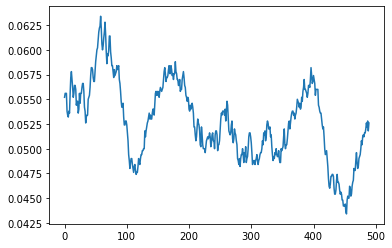

In [14]:
plt.plot(range(len(fp)),fp)

In [15]:
## with anomalies
M = 100   ## num of users
K = 540   ## days
D = 10    ## variables
anomaly_rate = 0.05

ids = ["ID"+str(i+1) for i in range(M)]
data_dict = {}
label_dict = {}
scale_list = np.random.uniform(0.3,3,size=D)
intercept_list = np.random.uniform(0.3,3,size=D)
loc_list = np.random.uniform(0,7,size=D)
m = np.zeros(D)
cor = np.ones((D,D))*0.6
for i in range(D):
  cor[i,i]=1
v = np.diag(scale_list).dot(cor).dot(np.diag(scale_list))
    
for ID in ids:
  data = np.zeros((K,D))
  random_error = np.random.multivariate_normal(m, v, size=K)
  for j in range(D):
    scale = scale_list[j]
    intercept = intercept_list[j]
    loc = loc_list[j]
    data[:,j] = np.array([scale*np.sin(2*math.pi/7*(x+loc)) for x in range(K)]) + \
                random_error[:,j] + intercept
  anomaly_index = np.random.choice(np.arange(K),size=int(K*anomaly_rate), replace=False)
  for i in anomaly_index:
    aberrant_num = np.random.choice(np.arange(int(D*0.4),int(D*0.8)))
    aberrant_col = np.random.choice(np.arange(D),aberrant_num,replace = False)
    data[i,aberrant_col] = data[i,aberrant_col]*np.random.uniform(1.5,3,size=aberrant_num)
  label = np.zeros(K)
  label[anomaly_index] = 1
  label_dict[ID] = label
  data_dict[ID] = data

In [16]:
global_params = [7,0.4,100,28*6,56,0.05,0.05,50]
pred_dict = online_anomaly_dectect(data_dict,global_params)
fp,fn,tp,tn = eval_perf(pred_dict,label_dict)

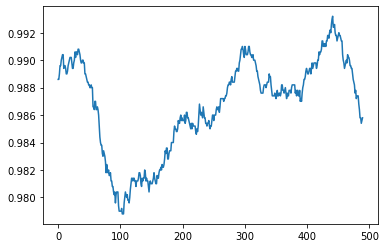

In [17]:
## accuracy
plt.plot(range(len(tp)),np.array(tp) + np.array(tn))

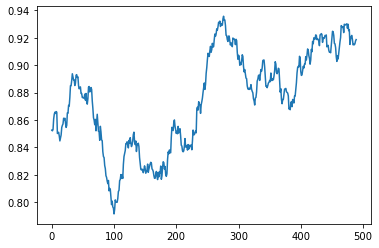

In [18]:
## sensitivity
plt.plot(range(len(tp)),np.array(tp)/(np.array(tp)+np.array(fn)))

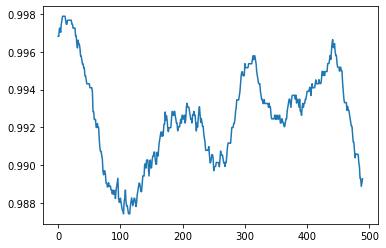

In [19]:
## specificity
plt.plot(range(len(tn)),np.array(tn)/(np.array(tn)+np.array(fp)))

In [20]:
## repeat 10 times to get a plot for average type 1 error, accuracy, etc
fp_list = []
for rep in range(10):
  ## without anomalies
  M = 100   ## num of users
  K = 540   ## days
  D = 10    ## variables 
  ids = ["ID"+str(i+1) for i in range(M)]
  data_dict = {}
  label_dict = {}
  scale_list = np.random.uniform(0.3,3,size=D)
  intercept_list = np.random.uniform(0.3,3,size=D)
  loc_list = np.random.uniform(0,7,size=D)
  m = np.zeros(D)
  cor = np.ones((D,D))*0.6
  for i in range(D):
    cor[i,i]=1
  v = np.diag(scale_list).dot(cor).dot(np.diag(scale_list))

  for ID in ids:
    data = np.zeros((K,D))
    random_error = np.random.multivariate_normal(m, v, size=K)
    for j in range(D):
      scale = scale_list[j]
      intercept = intercept_list[j]
      loc = loc_list[j]
      data[:,j] = np.array([scale*np.sin(2*math.pi/7*(x+loc)) for x in range(K)]) + \
                  random_error[:,j] + intercept
    data_dict[ID] = data
    label_dict[ID] = np.zeros(K)
  global_params = [7,0.4,100,28*6,56,0.05,0.05,50]
  pred_dict = online_anomaly_dectect(data_dict,global_params)
  fp,fn,tp,tn = eval_perf(pred_dict,label_dict)
  fp_list.append(fp)

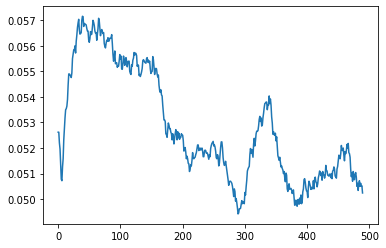

In [21]:
m_fp = []
for i in range(len(fp)):
  m_fp.append(np.mean(np.array([fp_list[j][i] for j in range(10)])))
plt.plot(range(len(m_fp)),m_fp)

In [22]:
fp_list = []
fn_list = []
tp_list = []
tn_list = []
for rep in range(10):
  ## with anomalies
  M = 100   ## num of users
  K = 540   ## days
  D = 10    ## variables
  anomaly_rate = 0.05

  ids = ["ID"+str(i+1) for i in range(M)]
  data_dict = {}
  label_dict = {}
  scale_list = np.random.uniform(0.3,3,size=D)
  intercept_list = np.random.uniform(0.3,3,size=D)
  loc_list = np.random.uniform(0,7,size=D)
  m = np.zeros(D)
  cor = np.ones((D,D))*0.6
  for i in range(D):
    cor[i,i]=1
  v = np.diag(scale_list).dot(cor).dot(np.diag(scale_list))

  for ID in ids:
    data = np.zeros((K,D))
    random_error = np.random.multivariate_normal(m, v, size=K)
    for j in range(D):
      scale = scale_list[j]
      intercept = intercept_list[j]
      loc = loc_list[j]
      data[:,j] = np.array([scale*np.sin(2*math.pi/7*(x+loc)) for x in range(K)]) + \
                  random_error[:,j] + intercept
    anomaly_index = np.random.choice(np.arange(K),size=int(K*anomaly_rate), replace=False)
    for i in anomaly_index:
      aberrant_num = np.random.choice(np.arange(int(D*0.4),int(D*0.8)))
      aberrant_col = np.random.choice(np.arange(D),aberrant_num,replace = False)
      data[i,aberrant_col] = data[i,aberrant_col]*np.random.uniform(1.5,3,size=aberrant_num)
    label = np.zeros(K)
    label[anomaly_index] = 1
    label_dict[ID] = label
    data_dict[ID] = data
  global_params = [7,0.4,100,28*6,56,0.05,0.05,50]
  pred_dict = online_anomaly_dectect(data_dict,global_params)
  fp,fn,tp,tn = eval_perf(pred_dict,label_dict)
  fp_list.append(fp)
  fn_list.append(fn)
  tp_list.append(tp)
  tn_list.append(tn)

In [23]:
m_fp = []
m_fn = []
m_tp = []
m_tn = []
for i in range(len(fp)):
  m_fp.append(np.mean(np.array([fp_list[j][i] for j in range(10)])))
  m_fn.append(np.mean(np.array([fn_list[j][i] for j in range(10)])))
  m_tp.append(np.mean(np.array([tp_list[j][i] for j in range(10)])))
  m_tn.append(np.mean(np.array([tn_list[j][i] for j in range(10)])))

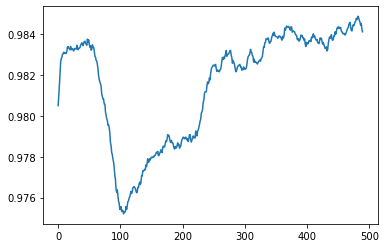

In [24]:
## accuracy
plt.plot(range(len(m_tp)),np.array(m_tp) + np.array(m_tn))

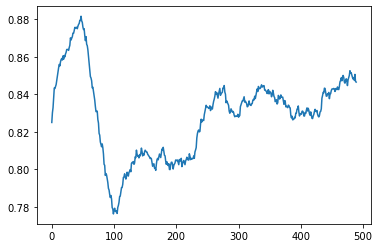

In [25]:
## sensitivity
plt.plot(range(len(m_tp)),np.array(m_tp)/(np.array(m_tp)+np.array(m_fn)))

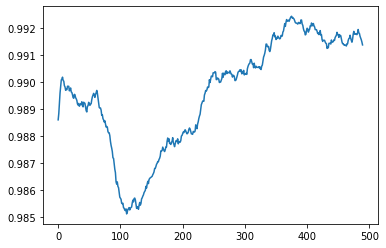

In [26]:
## specificity
plt.plot(range(len(m_tn)),np.array(m_tn)/(np.array(m_tn)+np.array(m_fp)))